In [1]:
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
import torch
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
boston = load_boston()

In [3]:
data = np.array(boston.data)
data.shape

(506, 13)

In [4]:
data = (data - data.mean(axis=0)) / data.std(axis=0)

In [5]:
X_train, X_test, y_train, y_test = train_test_split(data, boston.target, test_size=0.25, random_state=42)

In [25]:
class TorchLinearRegression:
    def __init__(self, lr=0.01, batch_size=10, num_epochs=10, std=True):
        self.std = std # standardization
        self.batch_size = batch_size
        self.num_epochs = num_epochs
        self.lr = lr
        
    def fit(self, X, y, debug=False):
        self.X = torch.tensor(X, dtype=torch.float32).cuda()
        self.y = torch.tensor(y, dtype=torch.float32).cuda()
        if self.std:
            self.X = (self.X - self.X.mean(dim=1, keepdim=True)) / self.X.std(dim=1, keepdim=True)
        self.dataset = TensorDataset(self.X, self.y)
        self.data_iter = DataLoader(self.dataset, self.batch_size, shuffle=True)
        self.model = torch.nn.Sequential(torch.nn.Linear(X.shape[1], 1)).cuda()
        self.loss = torch.nn.MSELoss()
        self.optimizer = torch.optim.SGD(self.model.parameters(), self.lr)
        self.losses = []

        for epoch in range(1, self.num_epochs + 1):
            for X_b, y_b in self.data_iter:
                self.optimizer.zero_grad()
                pred = self.model.forward(X_b).reshape(-1)
                loss = self.loss(pred, y_b)
                
                loss.backward()
                self.optimizer.step()
                
            pred = self.model.forward(self.X).reshape(-1)
            loss = self.loss(pred, self.y)
            self.losses.append(loss.item())
            if debug:
                print('epoch %d, loss: %f' % (epoch, loss.item()))
                
        self.bias = self.model[0].bias.data.item()
        self.weights = self.model[0].weight.data.reshape(-1).tolist()
    
    def predict(self, X):
        return self.model.forward(torch.tensor(X_test, dtype=torch.float32).cuda()).reshape(-1)
    
    def score(self, X, y):
        return self.loss(self.predict(X), torch.tensor(y_test, dtype=torch.float32).cuda()).item()

In [26]:
reg = TorchLinearRegression(num_epochs=20, lr=0.01)

In [27]:
reg.fit(X_train, y_train, debug=True)

epoch 1, loss: 131.667068
epoch 2, loss: 55.522079
epoch 3, loss: 37.127781
epoch 4, loss: 32.070766
epoch 5, loss: 30.596874
epoch 6, loss: 30.057636
epoch 7, loss: 29.832026
epoch 8, loss: 29.768520
epoch 9, loss: 29.672966
epoch 10, loss: 29.651041
epoch 11, loss: 29.609793
epoch 12, loss: 29.687759
epoch 13, loss: 29.854975
epoch 14, loss: 29.651167
epoch 15, loss: 29.651119
epoch 16, loss: 29.562132
epoch 17, loss: 29.560204
epoch 18, loss: 29.593220
epoch 19, loss: 30.129658
epoch 20, loss: 29.727322


In [28]:
reg.score(X_test, y_test)

28.182008743286133

In [29]:
reg.weights

[-2.2902586460113525,
 1.115311861038208,
 0.35506555438041687,
 1.6685271263122559,
 -0.7595237493515015,
 3.629495143890381,
 -0.5173917412757874,
 -1.8204773664474487,
 1.2740256786346436,
 -0.6326413154602051,
 -1.257485270500183,
 1.5385892391204834,
 -2.3122920989990234]

In [30]:
reg.bias

22.222183227539062

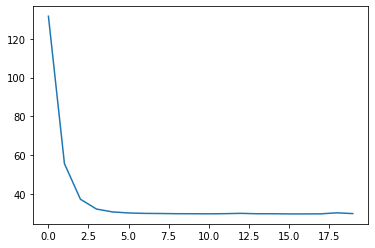

In [31]:
plt.plot(reg.losses)